Training accuracy: 0.97


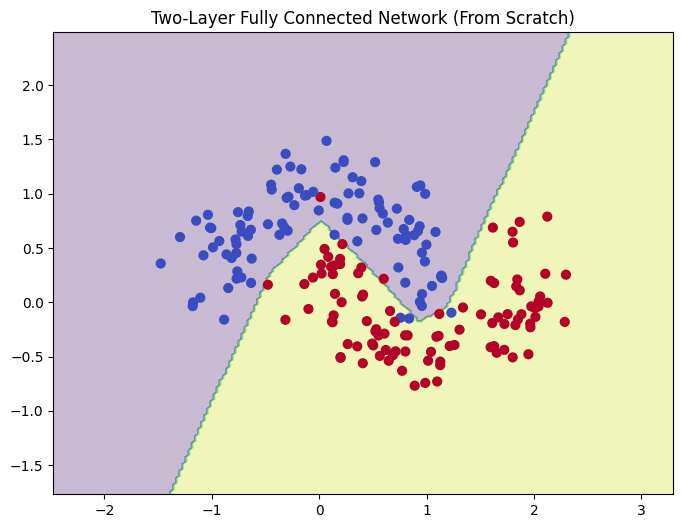

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons


class TwoLayerNN:
    def __init__(self, input_dim, hidden_dim, output_dim=1, lr=0.1, seed=42):
        np.random.seed(seed)
        self.lr = lr

        # Initialize parameters
        self.W1 = np.random.randn(input_dim, hidden_dim) * 0.1
        self.b1 = np.zeros((1, hidden_dim))
        self.W2 = np.random.randn(hidden_dim, output_dim) * 0.1
        self.b2 = np.zeros((1, output_dim))

    # Activation functions
    @staticmethod
    def relu(Z):
        return np.maximum(0, Z)

    @staticmethod
    def relu_derivative(Z):
        return (Z > 0).astype(float)

    @staticmethod
    def sigmoid(Z):
        return 1 / (1 + np.exp(-Z))

    # Forward pass
    def forward(self, X):
        self.Z1 = X @ self.W1 + self.b1
        self.A1 = self.relu(self.Z1)
        self.Z2 = self.A1 @ self.W2 + self.b2
        self.A2 = self.sigmoid(self.Z2)
        return self.A2

    # Loss function (Binary Cross-Entropy)
    @staticmethod
    def compute_loss(y, A2):
        return -np.mean(y*np.log(A2 + 1e-9) + (1-y)*np.log(1-A2 + 1e-9))

    # Backward pass
    def backward(self, X, y):
        m = len(y)

        dZ2 = self.A2 - y
        dW2 = (self.A1.T @ dZ2) / m
        db2 = np.sum(dZ2, axis=0, keepdims=True) / m

        dA1 = dZ2 @ self.W2.T
        dZ1 = dA1 * self.relu_derivative(self.Z1)
        dW1 = (X.T @ dZ1) / m
        db1 = np.sum(dZ1, axis=0, keepdims=True) / m

        # Update parameters
        self.W1 -= self.lr * dW1
        self.b1 -= self.lr * db1
        self.W2 -= self.lr * dW2
        self.b2 -= self.lr * db2

    # Training loop
    def train(self, X, y, epochs=5000):
        losses = []
        for _ in range(epochs):
            A2 = self.forward(X)
            loss = self.compute_loss(y, A2)
            losses.append(loss)
            self.backward(X, y)
        return losses

    # Prediction
    def predict(self, X):
        A2 = self.forward(X)
        return (A2 > 0.5).astype(int)


# 1️⃣ Create dataset
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
y = y.reshape(-1, 1)

# 2️⃣ Initialize and train model
model = TwoLayerNN(input_dim=2, hidden_dim=16, lr=0.1)
losses = model.train(X, y, epochs=5000)

# 3️⃣ Evaluate
y_pred = model.predict(X)
print("Training accuracy:", np.mean(y_pred == y))


# 4️⃣ Visualization
plt.figure(figsize=(8,6))

x_min, x_max = X[:, 0].min()-1, X[:, 0].max()+1
y_min, y_max = X[:, 1].min()-1, X[:, 1].max()+1
xx, yy = np.meshgrid(np.linspace(x_min, x_max, 200),
                     np.linspace(y_min, y_max, 200))

grid = np.c_[xx.ravel(), yy.ravel()]
Z = model.predict(grid)
Z = Z.reshape(xx.shape)

plt.contourf(xx, yy, Z, alpha=0.3)
plt.scatter(X[:, 0], X[:, 1], c=y.flatten(), cmap='coolwarm', s=40)

plt.title("Two-Layer Fully Connected Network (From Scratch)")
plt.show()


Epoch [1/5000]  Loss: 0.685235
Epoch [500/5000]  Loss: 0.074484
Epoch [1000/5000]  Loss: 0.059639
Epoch [1500/5000]  Loss: 0.052672
Epoch [2000/5000]  Loss: 0.044754
Epoch [2500/5000]  Loss: 0.037343
Epoch [3000/5000]  Loss: 0.031513
Epoch [3500/5000]  Loss: 0.027567
Epoch [4000/5000]  Loss: 0.024971
Epoch [4500/5000]  Loss: 0.023341
Epoch [5000/5000]  Loss: 0.022266

Final Loss: 0.022266
Training accuracy: 0.9900000095367432


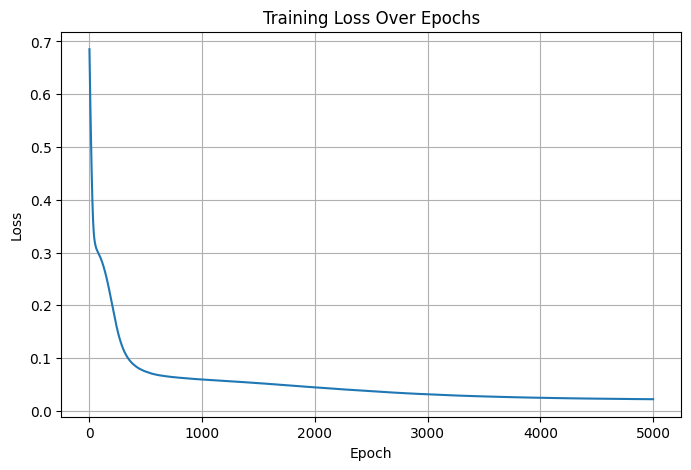

In [6]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_moons

# 1️⃣ Create dataset
X, y = make_moons(n_samples=200, noise=0.2, random_state=42)
X = torch.tensor(X, dtype=torch.float32)
y = torch.tensor(y.reshape(-1, 1), dtype=torch.float32)

# 2️⃣ Define Model
class TwoLayerNet(nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim):
        super(TwoLayerNet, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_dim, output_dim)

    def forward(self, x):
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)   # No sigmoid (handled by BCEWithLogitsLoss)
        return x

# 3️⃣ Initialize model
model = TwoLayerNet(input_dim=2, hidden_dim=16, output_dim=1)

# 4️⃣ Loss + Optimizer
criterion = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

# 5️⃣ Training loop
epochs = 5000
losses = []

for epoch in range(epochs):

    outputs = model(X)
    loss = criterion(outputs, y)
    losses.append(loss.item())

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # 🔎 Print loss iteratively
    if (epoch + 1) % 500 == 0 or epoch == 0:
        print(f"Epoch [{epoch+1}/{epochs}]  Loss: {loss.item():.6f}")

print(f"\nFinal Loss: {losses[-1]:.6f}")

# 6️⃣ Prediction
with torch.no_grad():
    logits = model(X)
    probs = torch.sigmoid(logits)
    y_pred = (probs > 0.5).float()

accuracy = (y_pred == y).float().mean()
print("Training accuracy:", accuracy.item())

# 7️⃣ Plot Loss Curve
plt.figure(figsize=(8,5))
plt.plot(losses)
plt.title("Training Loss Over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


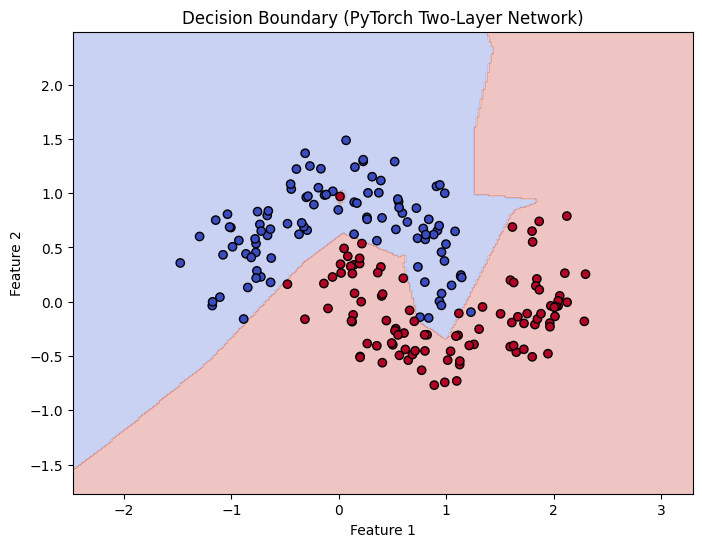

In [8]:
# 7️⃣ Decision Boundary Visualization
plt.figure(figsize=(8,6))
X_np, y_np = make_moons(n_samples=200, noise=0.2, random_state=42)

# Create mesh grid
x_min, x_max = X_np[:, 0].min() - 1, X_np[:, 0].max() + 1
y_min, y_max = X_np[:, 1].min() - 1, X_np[:, 1].max() + 1

xx, yy = np.meshgrid(
    np.linspace(x_min, x_max, 300),
    np.linspace(y_min, y_max, 300)
)

grid = np.c_[xx.ravel(), yy.ravel()]
grid_tensor = torch.tensor(grid, dtype=torch.float32)

# Predict over grid
with torch.no_grad():
    logits = model(grid_tensor)
    probs = torch.sigmoid(logits)
    Z = (probs > 0.5).float()

Z = Z.numpy().reshape(xx.shape)

# Plot decision surface
plt.contourf(xx, yy, Z, alpha=0.3, cmap="coolwarm")

# Plot training points
plt.scatter(X_np[:, 0], X_np[:, 1], c=y_np, cmap="coolwarm", edgecolors='k')

plt.title("Decision Boundary (PyTorch Two-Layer Network)")
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.show()